# Simple plane wave example

This Jupyter notebook provides an introduction to the basic usage of Fullwave 2.5.

## Overview

As shown below, we will demonstrate the propagation of a simple plane wave through a simple object.

### Medium

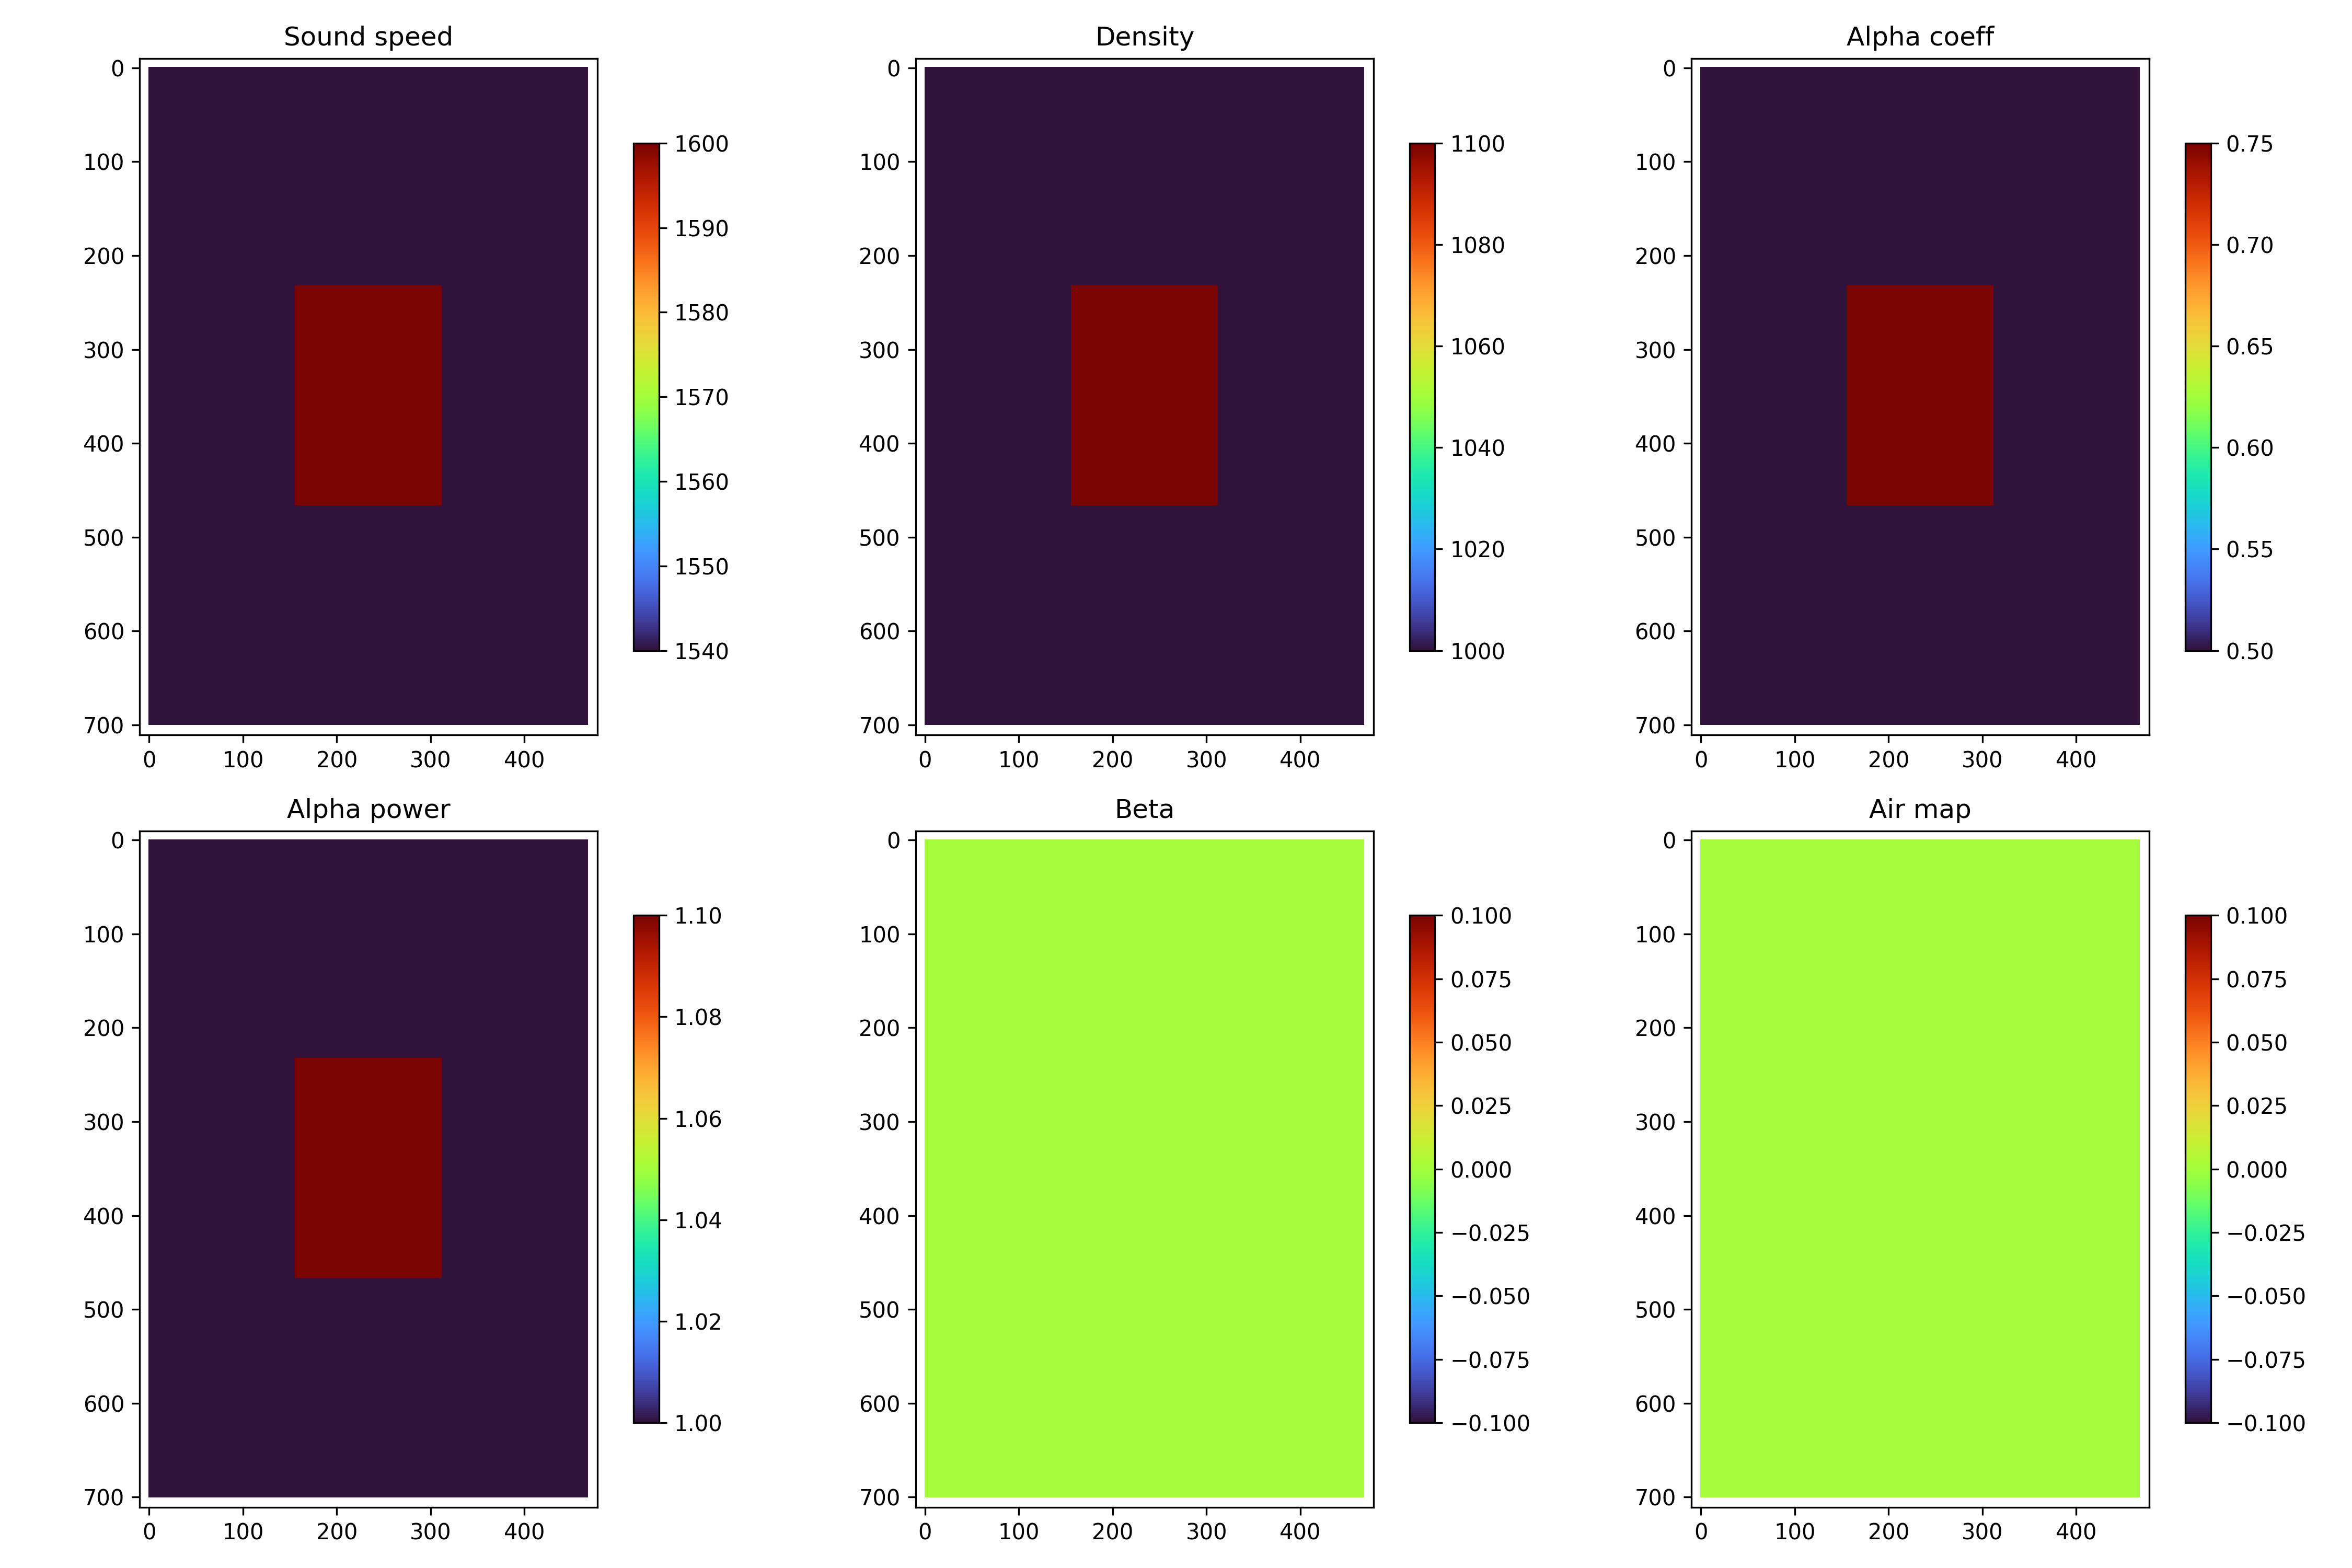

### Wave propagation snapshot

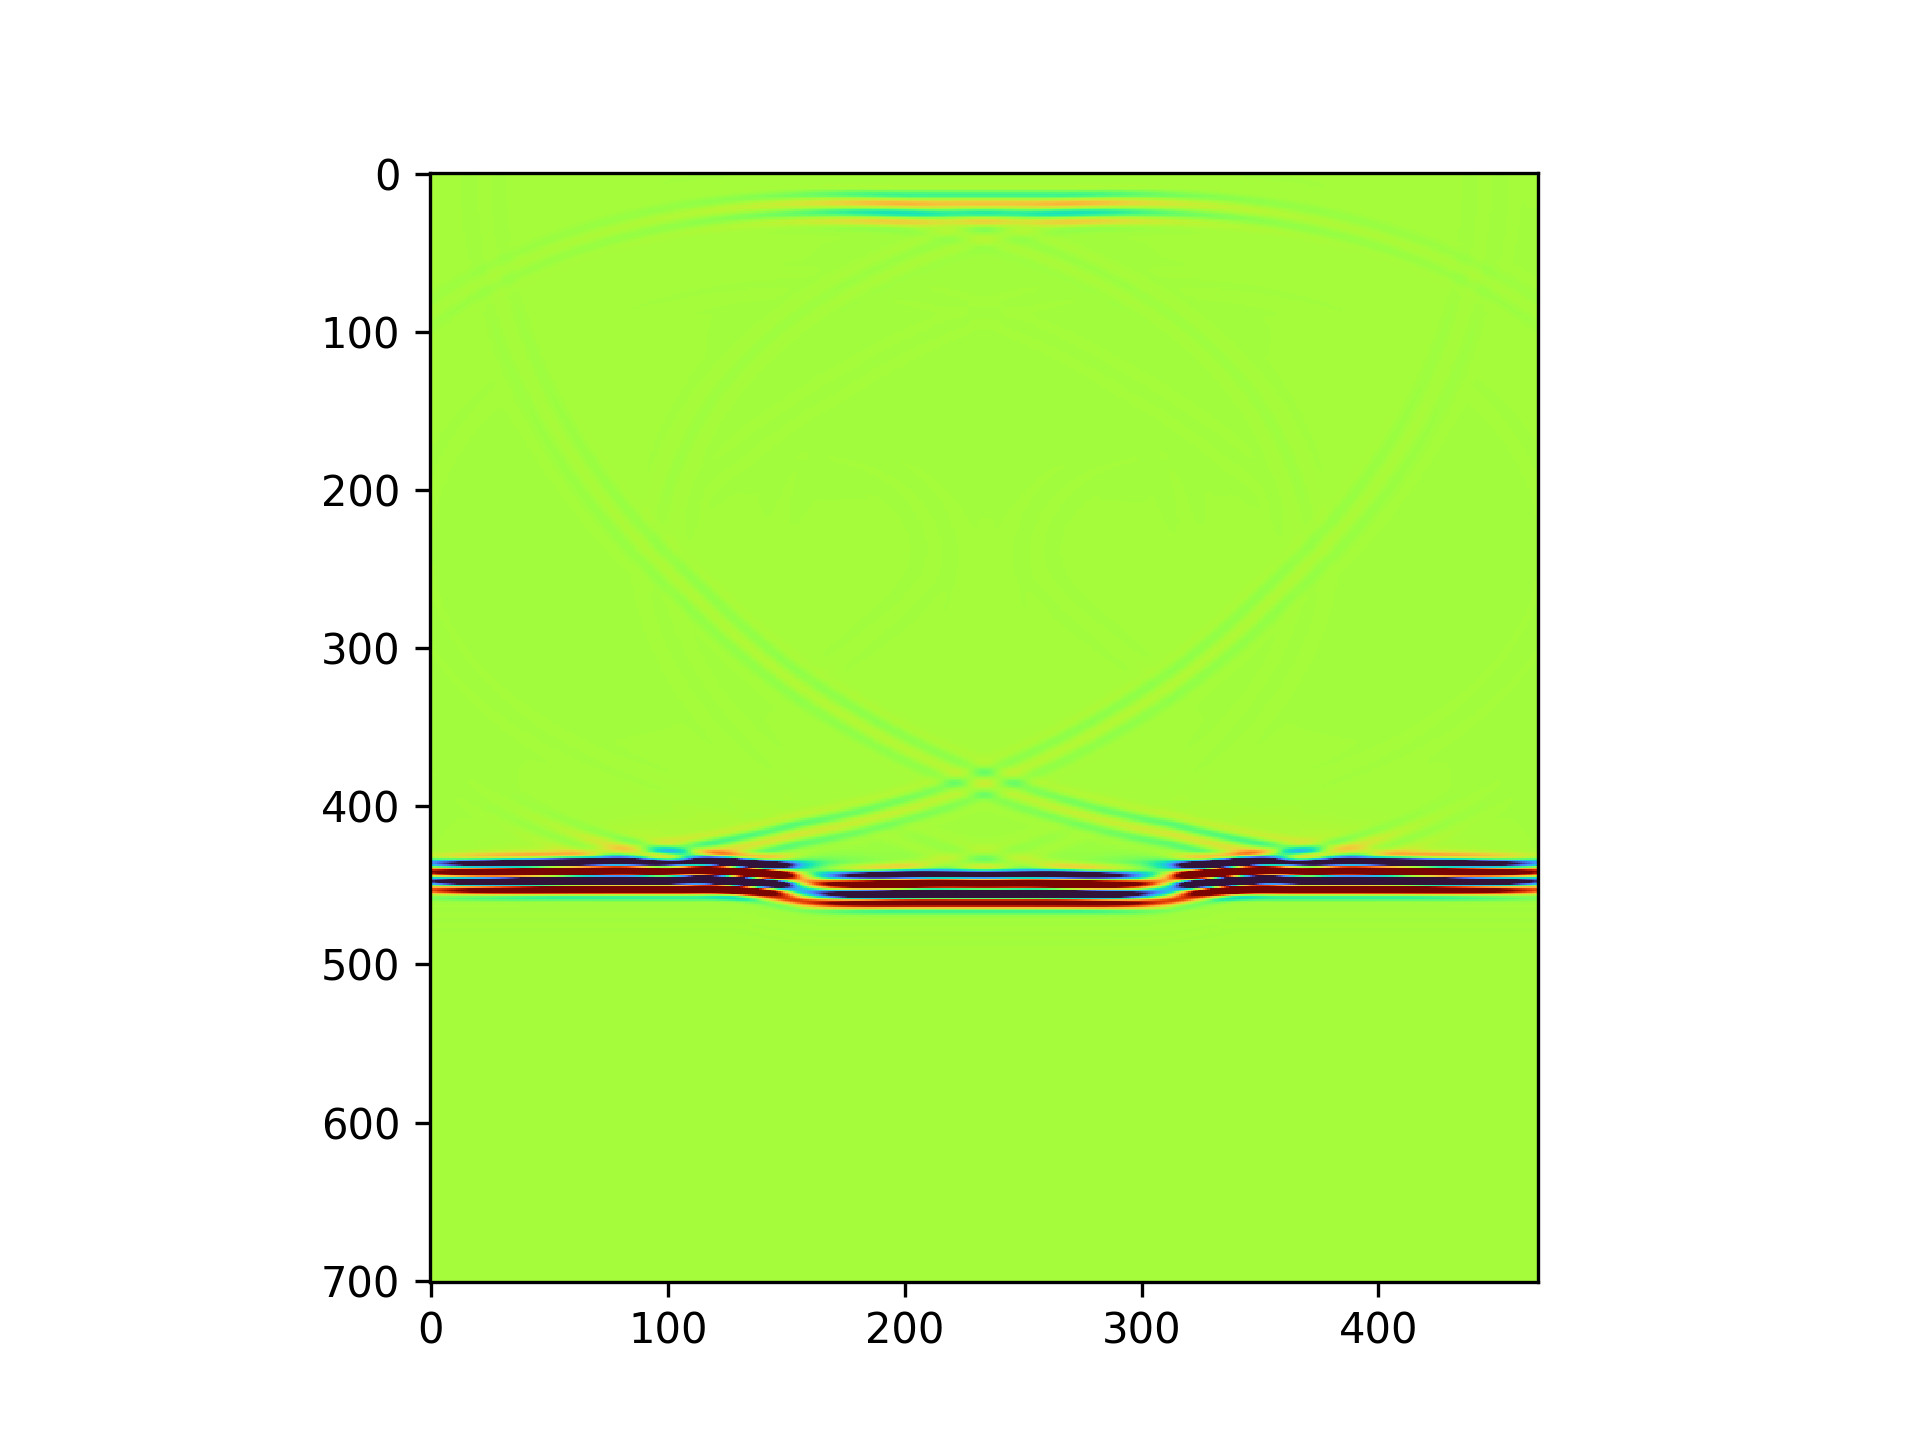


## Prerequisites

Before running this notebook, ensure that you have Fullwave 2.5 and its dependencies installed.

You can follow the installation instructions provided in the [Fullwave 2.5 GitHub repository](https://github.com/pinton-lab/fullwave25#install)


## Basic steps

The basic steps are as follows:

1. Preparation
   1. Import necessary libraries and modules.
   2. Define the working directory.
2. Simulation configuration
   1. Define the computational grid parameters. (`fullwave.Grid`)
   2. Define the acoustic medium properties. (`fullwave.Medium`)
   3. Define the acoustic source position and the time-varying source signal. (`fullwave.Source`)
   4. Define the sensor positions to record the wavefield. (`fullwave.Sensor`)
3. Simulation setup
   1. Initialize the Fullwave solver object with the defined parameters. (`fullwave.Solver`)
   2. Execute the simulation.
4. Post-process
   1. Load the recorded wavefield data.
   2. visualize the results.


## Step 1: Preparation

### Step 1.1: Import necessary libraries and modules

In this step, we import the required libraries and modules for the simulation. We use `pathlib` for handling file paths, `numpy` for numerical operations, and `fullwave` along with its utility functions for wave propagation simulations and data visualization.


In [1]:
# pathlib for handling file paths
from pathlib import Path

# numpy for numerical operations
import numpy as np

# fullwave library and its utility functions
import fullwave
from fullwave.utils import plot_utils, signal_process

### Step 1.2: Define the working directory

In this step, we set up the working directory where simulation outputs will be saved.
Using the `Path` module from the `pathlib` library, we define the path to the working directory.


In [2]:
# we will make a working directory called "simple_plane_wave" inside "outputs" directory.
work_dir = Path("./outputs/") / "simple_plane_wave"

# create the working directory if it does not exist
work_dir.mkdir(parents=True, exist_ok=True)

## Step 2

### Step 2.1: Define the computational grid parameters. (`fullwave.Grid`)

In this step, we define the computational grid parameters using the `fullwave.Grid` class. This includes specifying the domain size (`domain_size`) in meters, center frequency (`f0`) of the source in Hz, base sound speed (`c0`) in m/s, and duration (`duration`) of the simulation in seconds.

As an optional step, we can also define spatial resolution (`ppw`) and temporal resolution (`cfl`). If not specified, these will be set to default values.


In [3]:
domain_size = (3e-2, 2e-2)  # meters
f0 = 3e6  # Hz
c0 = 1540  # m/s
duration = domain_size[0] / c0 * 2  # seconds

# setup the Grid instance
grid = fullwave.Grid(
    domain_size=domain_size,
    f0=f0,
    duration=duration,
    c0=c0,
)

`Grid` class calculates the necessary grid spacing (`dx`, `dy`), time step (`dt`), domain size in grid points (`nx`, `ny`), and number of time steps (`nt`) based on the provided parameters to ensure accurate wave propagation simulation.


You can acess these calculated parameters as attributes of the `grid` object.


In [4]:
print(f"dx: {grid.dx:.2e} m")
print(f"dy: {grid.dy:.2e} m")
print(f"dt: {grid.dt:.2e} s")
print(f"nx: {grid.nx} points")
print(f"ny: {grid.ny} points")
print(f"nt: {grid.nt} time steps")
print(f"Simulation duration: {grid.duration:.2e} s")
print(f"Points per wavelength: {grid.ppw}")
print(f"Courant-Friedrichs-Lewy (CFL) number: {grid.cfl}")
print(f"Wavelength: {grid.wavelength:.2e} m")

dx: 4.28e-05 m
dy: 4.28e-05 m
dt: 5.56e-09 s
nx: 701 points
ny: 468 points
nt: 7013 time steps
Simulation duration: 3.90e-05 s
Points per wavelength: 12
Courant-Friedrichs-Lewy (CFL) number: 0.2
Wavelength: 5.13e-04 m


or, you can print the summary more easily by using the `print_grid_info` function.


In [5]:
grid.print_info()

Grid Information:
  Domain size (axial, lateral) (grid.domain_size): (3.00e-02 m, 2.00e-02 m)
  Center frequency: (grid.f0) 3.0 MHz
  Duration: (grid.duration) 3.90e-05 s
  Speed of sound (grid.c0): 1540 m/s
  Points per wavelength (PPW) (grid.ppw): 12
  Courant-Friedrichs-Lewy (CFL) number (grid.cfl): 0.2
  Wavelength (grid.wavelength): 5.13e-01 m
  Grid spacing (grid.dx, grid.dy): (4.28e-02 m, 4.28e-02 m)
  Number of grid points (grid.nx, grid.ny): (701, 468)
  Time step (grid.dt): 5.56e-09 sec
  Number of time steps (grid.nt): 7013
  is 3D simulation (grid.is_3d): False


### Step 2.2: Define the acoustic medium properties. (`fullwave.Medium`)

In this step, we define the acoustic medium properties using the `fullwave.Medium` class.

We specify the sound speed (`c`), density (`rho`), attenuation coefficient (`alpha_coeff`), attenuation power law exponent (`alpha_power`), and nonlinearity parameter (`beta`) of the medium as 2D NumPy arrays.

In this example, the medium is initialized with a uniform value, and an object with different properties is embedded in the center of the medium.


First, we define the base medium properties as 2D NumPy arrays.


In [6]:
# Define the base 2D medium arrays
sound_speed_map = 1540 * np.ones((grid.nx, grid.ny))  # m/s
density_map = 1000 * np.ones((grid.nx, grid.ny))  # kg/m^3
alpha_coeff_map = 0.5 * np.ones((grid.nx, grid.ny))  # dB/(MHz^y cm)
alpha_power_map = 1.0 * np.ones((grid.nx, grid.ny))  # power law exponent
beta_map = 0.0 * np.ones((grid.nx, grid.ny))  # nonlinearity parameter

# embed an object with different properties in the center of the medium
obj_x_start = grid.nx // 3
obj_x_end = 2 * grid.nx // 3
obj_y_start = grid.ny // 3
obj_y_end = 2 * grid.ny // 3

sound_speed_map[obj_x_start:obj_x_end, obj_y_start:obj_y_end] = 1600  # m/s
density_map[obj_x_start:obj_x_end, obj_y_start:obj_y_end] = 1100  # kg/m^3
alpha_coeff_map[obj_x_start:obj_x_end, obj_y_start:obj_y_end] = 0.75  # dB/(MHz^y cm)
alpha_power_map[obj_x_start:obj_x_end, obj_y_start:obj_y_end] = 1.1  # power law exponent
beta_map[obj_x_start:obj_x_end, obj_y_start:obj_y_end] = 0.0  # nonlinearity parameter

As a next step, we initialize the `Medium` object with the defined properties.


In [7]:
medium = fullwave.Medium(
    grid=grid,
    sound_speed=sound_speed_map,
    density=density_map,
    alpha_coeff=alpha_coeff_map,
    alpha_power=alpha_power_map,
    beta=beta_map,
)

The `Medium` class takes the computational grid (`grid`) and the defined medium properties as inputs to create a medium object that can be used in the wave propagation simulation.

You can visualize the defined medium properties using the `plot` method of the `Medium` class.


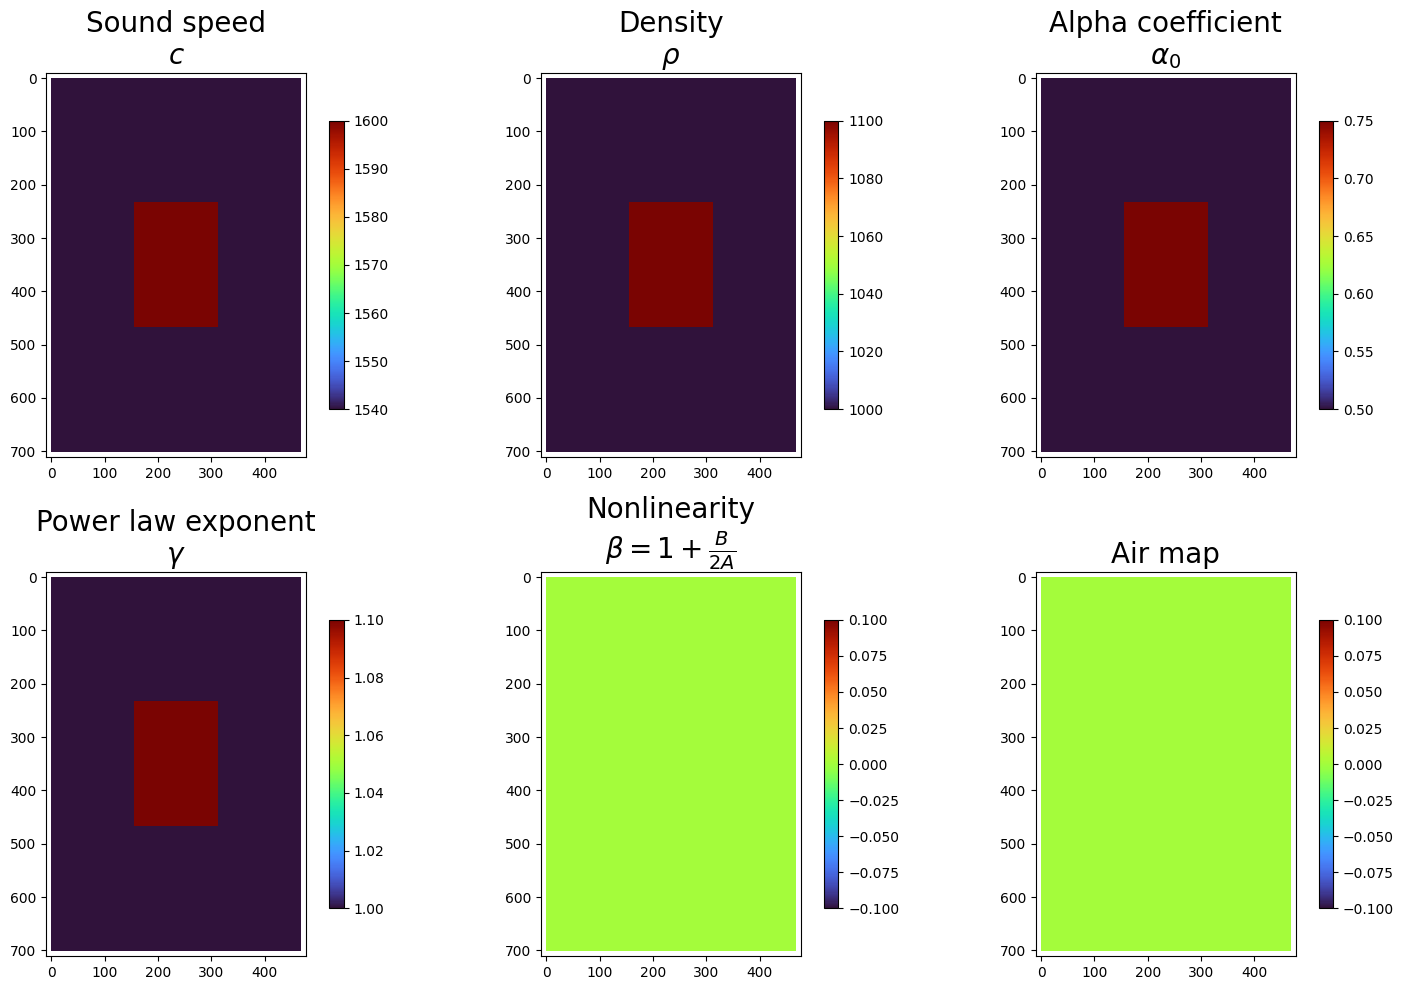

In [8]:
medium.plot(show=True, export_path=work_dir / "medium.png")

`Medium` class summarizes the medium properties and provides a visualization method to plot the sound speed, density, attenuation coefficient, and nonlinearity parameter distributions.

We can print the summary of the medium properties using the `print_info` method similar to the `Grid` class.


In [9]:
medium.print_info()

Medium: 
  Grid: Grid Information:
  Domain size (axial, lateral) (grid.domain_size): (3.00e-02 m, 2.00e-02 m)
  Center frequency: (grid.f0) 3.0 MHz
  Duration: (grid.duration) 3.90e-05 s
  Speed of sound (grid.c0): 1540 m/s
  Points per wavelength (PPW) (grid.ppw): 12
  Courant-Friedrichs-Lewy (CFL) number (grid.cfl): 0.2
  Wavelength (grid.wavelength): 5.13e-01 m
  Grid spacing (grid.dx, grid.dy): (4.28e-02 m, 4.28e-02 m)
  Number of grid points (grid.nx, grid.ny): (701, 468)
  Time step (grid.dt): 5.56e-09 sec
  Number of time steps (grid.nt): 7013
  is 3D simulation (grid.is_3d): False

  Sound speed: min=1540.00, max=1600.00
  Density: min=1000.00, max=1100.00
  Alpha coeff: min=0.50, max=0.75
  Alpha power: min=1.00, max=1.10
  Beta: min=0.00, max=0.00
  Number of air coords: 0
  Attenuation builder: lookup



### Step 2.3: Define the acoustic source position and the time-varying source signal. (`fullwave.Source`)

In this step, we define the acoustic source position and the time-varying source signal using the `fullwave.Source` class.

We specify the source position as a 2D mask array, where the source location is marked with a value of 1, and all other locations are marked with 0.


In [10]:
# define where to put the pressure source [nx, ny]
p_mask = np.zeros((grid.nx, grid.ny), dtype=bool)

# set the source location at the top row of the grid
p_mask[0:1, :] = True

Next, we define the time-varying source signal as a NumPy array. In this example, we use a simple gaussian-modulated sinusoidal pulse as the source signal. center frequency, number of cycles, drop off, and maximum amplitude are specified to generate the source signal.


In [11]:
# define the pressure source [n_sources, nt]

# create a gaussian-modulated sinusoidal pulse as the source signal
p0_vec = fullwave.utils.pulse.gaussian_modulated_sinusoidal_signal(
    nt=grid.nt,  # number of time steps
    f0=f0,  # center frequency [Hz]
    duration=duration,  # duration [s]
    ncycles=2,  # number of cycles
    drop_off=2,  # drop off factor
    p0=1e5,  # maximum amplitude [Pa]
)  # [nt]

# expand p0_vec to match the number of source locations
p0 = np.zeros((p_mask.sum(), grid.nt))  # [n_sources, nt]

# assign the source signal to all source locations
p0[:] = p0_vec  # [n_sources, nt]

As a next step, we initialize the `Source` object with the defined source position and source signal.
The `Source` class takes the computational grid (`grid`), source position mask, and source signal as inputs to create a source object that can be used in the wave propagation simulation.


In [12]:
# setup the Source instance
source = fullwave.Source(p0, p_mask)

We can print the summary of the medium properties using the `print_info` method similar to the `Grid` class.


In [13]:
source.print_info()

Source: 
  Number of sources: 468
  Grid shape: (701, 468)
  Is 3D: False
  p0 shape: (468, 7013)



We can plot the source location with the `source.plot()` method.


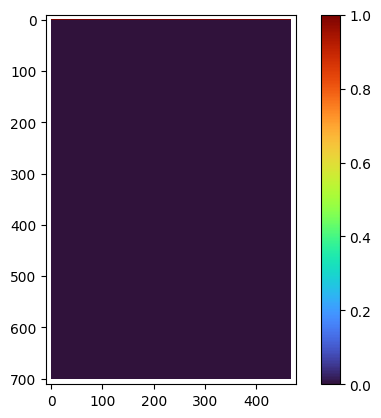

In [14]:
source.plot(show=True, export_path=work_dir / "source.png")

Since the source location is at the edge of the domain, it may not be clearly visible in the plot.

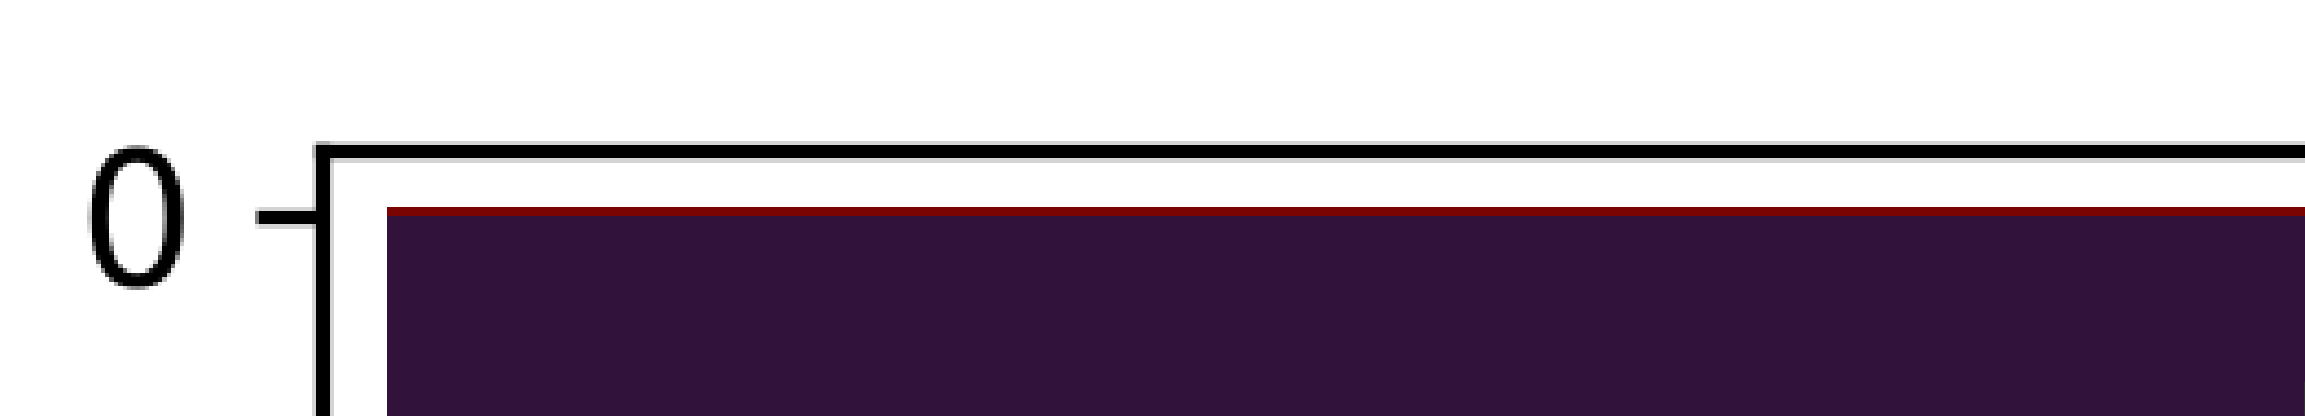


We can visualize the defined source signal using the `plot_1d_array` function from the `plot_utils` module.


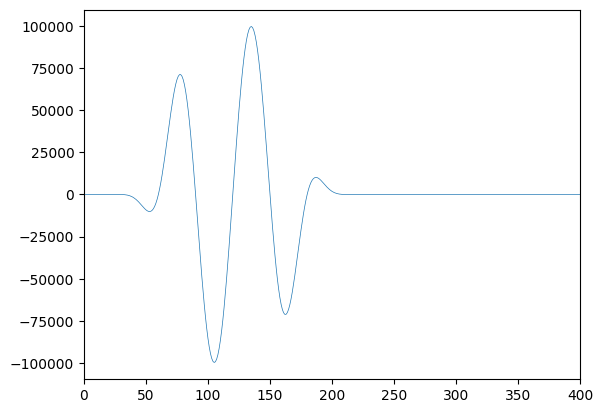

In [15]:
plot_utils.plot_1d_array(
    p0_vec,
    show=True,
    xlim=(0, 400),
    export_path=work_dir / "source_signal.png",
)

We can also visualise the source signal matrix using the plot_array function from the plot_utils module.


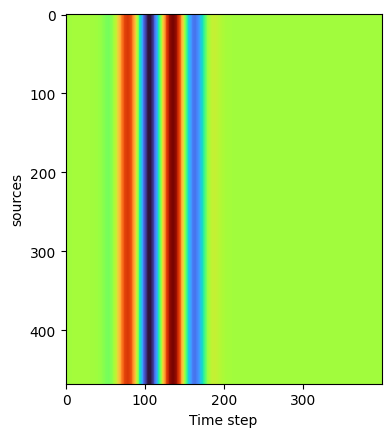

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [16]:
plot_utils.plot_array(
    p0[:, :400],
    show=True,
    export_path=work_dir / "source_signal_matrix.png",
    xlabel="Time step",
    ylabel="sources",
)

### step2.4: Define the sensor positions to record the wavefield. (`fullwave.Sensor`)

In this step, we define the sensor positions to record the wavefield using the `fullwave.Sensor` class.
We specify the sensor positions as a 2D mask array, where the sensor locations are marked with a value of 1, and all other locations are marked with 0, similar to the source position definition.

Since we want to record the wavefield at all grid points in this example, we set the entire mask to 1.


In [17]:
sensor_mask = np.zeros((grid.nx, grid.ny), dtype=bool)
sensor_mask[:, :] = True

Next, we initialize the `Sensor` object with the defined sensor position mask.
The `Sensor` class takes the sensor position mask as inputs to create a sensor object that can be used in the wave propagation simulation.

We can also define the sampling modulus time for the sensor recordings with `sampling_modulus_time` parameter.
This parameter allows us to control the temporal resolution of the recorded data by specifying how often to record the wavefield during the simulation.
By setting `sampling_modulus_time` to a value greater than 1, we can reduce the size of the output data by recording the wavefield at every nth time step.


In [18]:
sensor = fullwave.Sensor(mask=sensor_mask, sampling_modulus_time=7)

We can print the summary of the medium properties using the `print_info` method similar to the `Grid` class.


In [19]:
sensor.print_info()

Sensor: 
  Number of sensors: 328068
  Grid shape: (701, 468)
  Is 3D: False



We can plot the sensor location with the `sensor.plot()` method.

The whole domain is covered with sensors in this example, so the plot will show the array filled with ones.


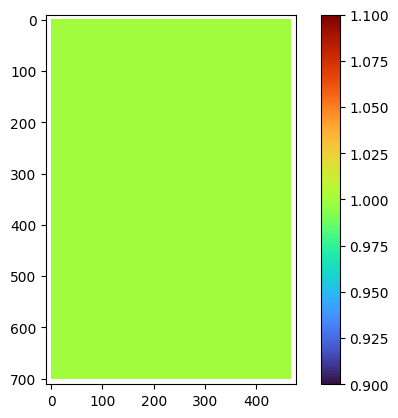

In [20]:
sensor.plot(show=True, export_path=work_dir / "sensor.png")

## Step 3. Simulation setup

The simulation configuration is done!
Next, we pass the configured parameters to the Fullwave solver.


### Step 3.1: Initialize the Fullwave solver object with the defined parameters. (`fullwave.Solver`)

The `Solver` class takes the working directory (`work_dir`), computational grid (`grid`), acoustic medium (`medium`), acoustic source (`source`), and sensor (`sensor`) as inputs to create a solver object that can be used to run the wave propagation simulation.

We can specify additional parameters such as `run_on_memory`
`run_on_memory` set to `True` can speed up the simulation significantly, but it requires more RAM. If you have sufficient memory, you can set it to `True` for faster execution. This is especially useful for large-scale simulations where disk I/O can become a bottleneck.
However, The simulation output will be writtein in memory and will not be saved to disk when `run_on_memory` is set to `True`. Make sure to consider this when choosing the setting based on your system's capabilities and simulation requirements.


In [21]:
fw_solver = fullwave.Solver(
    work_dir=work_dir,
    grid=grid,
    medium=medium,
    source=source,
    sensor=sensor,
    run_on_memory=False,
)

We can print the summary of the solver properties using the `print_info` method similar to the `Grid` class.


In [22]:
fw_solver.print_info()


Solver(
  work_dir=outputs/simple_plane_wave

  medium=Medium: 
  Grid: Grid Information:
  Domain size (axial, lateral) (grid.domain_size): (3.00e-02 m, 2.00e-02 m)
  Center frequency: (grid.f0) 3.0 MHz
  Duration: (grid.duration) 3.90e-05 s
  Speed of sound (grid.c0): 1540 m/s
  Points per wavelength (PPW) (grid.ppw): 12
  Courant-Friedrichs-Lewy (CFL) number (grid.cfl): 0.2
  Wavelength (grid.wavelength): 5.13e-01 m
  Grid spacing (grid.dx, grid.dy): (4.28e-02 m, 4.28e-02 m)
  Number of grid points (grid.nx, grid.ny): (701, 468)
  Time step (grid.dt): 5.56e-09 sec
  Number of time steps (grid.nt): 7013
  is 3D simulation (grid.is_3d): False

  Sound speed: min=1540.00, max=1600.00
  Density: min=1000.00, max=1100.00
  Alpha coeff: min=0.50, max=0.75
  Alpha power: min=1.00, max=1.10
  Beta: min=0.00, max=0.00
  Number of air coords: 0
  Attenuation builder: lookup

  source=Source: 
  Number of sources: 468
  Grid shape: (701, 468)
  Is 3D: False
  p0 shape: (468, 7013)

  sensor=S

### Step 3.2: Execute the simulation.


Now, all of the configurations are set up, and we can run the simulation using the `run` method of the `Solver` class.
The `run` method executes the wave propagation simulation based on the defined grid, medium, source, and sensor configurations.
It performs the necessary computations to simulate the wave propagation and records the wavefield data at the specified sensor locations.


In [23]:
sensor_output = fw_solver.run()

## Step 4. Post-process

The simulation is complete!
Next, we will load and visualize the recorded wavefield data.


### Step 4.1 reshape the recorded wavefield data.

`sensor_output` contains the recorded wavefield data at the sensor locations after the simulation is complete.
But the data is in 1D array format, so we need to reshape it back to the original 2D grid format for further analysis and visualization.

We can use `signal_process.reshape_whole_sensor_to_nt_nx_ny` function from the `fullwave.utils.signal_process` module to reshape the recorded wavefield data.


In [24]:
propagation_map = signal_process.reshape_whole_sensor_to_nt_nx_ny(
    sensor_output,
    grid,
)

### Step 4.2. visualize the results.

We can visualize the wave propagation using the `plot_utils.plot_array` function from the `fullwave.utils.plot_utils` module.


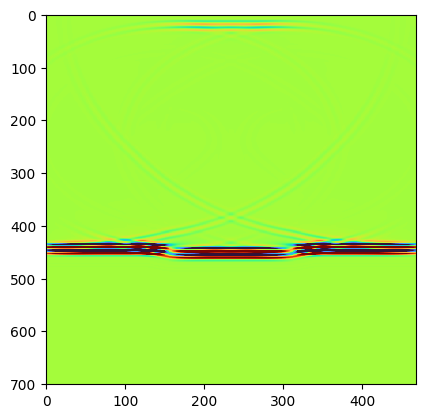

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [25]:
p_max_plot = np.abs(propagation_map).max().item() / 4
time_step = propagation_map.shape[0] // 3
plot_utils.plot_array(
    propagation_map[time_step, :, :],
    aspect=propagation_map.shape[2] / propagation_map.shape[1],
    export_path=work_dir / "wave_propagation_snapshot_1.png",
    vmax=p_max_plot,
    vmin=-p_max_plot,
    show=True,
)

We can visualize the wave propagation animation using the `plot_utils.plot_wave_propagation_with_map` function from the `fullwave.utils.plot_utils` module as well.


plotting animation: 100%|██████████| 51/51 [00:00<00:00, 948.11it/s]


<Figure size 640x480 with 0 Axes>

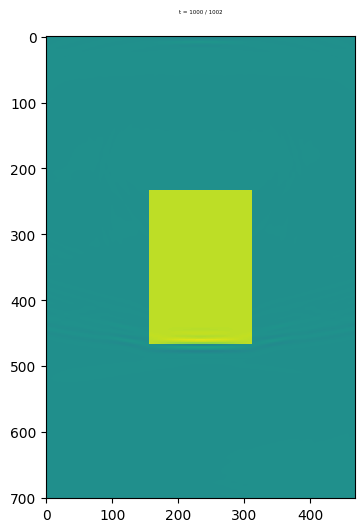

In [26]:
plot_utils.plot_wave_propagation_with_map(
    propagation_map=propagation_map,
    c_map=medium.sound_speed,
    rho_map=medium.density,
    export_name=work_dir / "wave_propagation_animation.mp4",
    vmax=p_max_plot,
    vmin=-p_max_plot,
)